In [ ]:
## Initial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from tqdm import tqdm
import datetime as dt
import csv
import json
import io
import math
import requests
# from trueskill import Ranking
import elo
import warnings

warnings.filterwarnings('ignore')

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

In [ ]:
## Helper Functions

def time_convert(x):
    if len(x.split(':')) == 3:
        h,m,s = map(int,x.split(':'))
        return (h)*60 + (m)
    else:
        m,s = map(int,x.split(':'))
        return (m) + (s/60)

def get_date(x):
    year, month, day, spare = map(str,x.split('-'))
    return dt.datetime(int(year), int(month), int(day))

def bin_times(x):
    if x < dt.time(12,0,0):
        return "Morning"
    elif x < dt.time(16,30,0):
        return "Afternoon"
    else:
        return "Night"

In [ ]:
## Data Cleaning

master_data = pd.read_csv('Data/CardioActivities.csv')

master_data = master_data[master_data["GPX File"].notna()] # Clean values with no date

master_data["Time"] = pd.to_datetime(master_data.Date).dt.time
master_data["Time_Bin"] = master_data.Time.apply(bin_times)

master_data["Time_Bin"] = pd.Categorical(master_data["Time_Bin"],["Morning","Afternoon","Night"])

master_data["Pace"] = master_data["Average Pace"].apply(time_convert)
master_data["Distance"] = master_data["Distance (km)"]
master_data["Date"] = master_data["GPX File"].apply(get_date)
master_data["Speed"] = master_data["Average Speed (km/h)"]
master_data["Duration"] = master_data["Duration"].apply(time_convert)
master_data = master_data[(master_data.Pace < 7) & (master_data.Distance > 3)]

master_data['Rolling_Dist'] = master_data.Distance.rolling(10).median()
master_data['Rolling_Pace'] = master_data.Pace.rolling(15).mean()
master_data['Rolling_Speed'] = master_data.Speed.rolling(15).median()
master_data['Rolling_Duration'] = master_data.Duration.rolling(10).median()
master_data['Rolling_Calories'] = master_data["Calories Burned"].rolling(10).median()
master_data['Rolling_Climb'] = master_data["Climb (m)"].rolling(10).median()

clean_data_y1 =  master_data[(master_data.Date < dt.datetime(2021,9,20))]
clean_data_y2 = master_data[(master_data.Date >= dt.datetime(2021,9,20))]

In [ ]:
## Time of Day

binned_data = master_data.sort_values("Time_Bin")

fig, ax1 = plt.subplots(1,1,figsize=(16,9))
sns.histplot(binned_data.Time_Bin)
ax1.set_xlabel("")
ax1.set_title("Activties vs Time of Day")
sns.despine()
plt.savefig("Graphs/Time_of_Day.jpg")

fig, ax1 = plt.subplots(1,1,figsize=(16,9))
sns.despine()
ax1.set_title("Time of Day vs Pace")
sns.boxplot(binned_data.Time_Bin,binned_data.Pace)
ax1.set_xlabel("")
ax1.set_ylabel("Pace (min/km)")
plt.savefig("Graphs/Time_Pace.jpg")

fig, ax1 = plt.subplots(1,1,figsize=(16,9))
sns.despine()
ax1.set_title("Time of Day vs Distance")
sns.boxplot(binned_data.Time_Bin,binned_data.Distance)
ax1.set_xlabel("")
ax1.set_ylabel("Distance (km)")
plt.savefig("Graphs/Time_Distance.jpg")

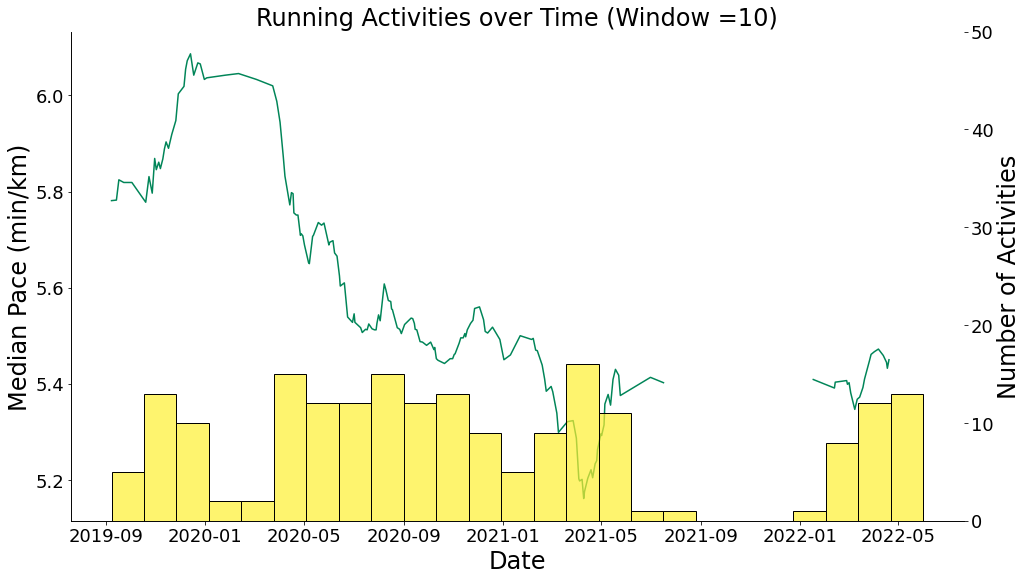

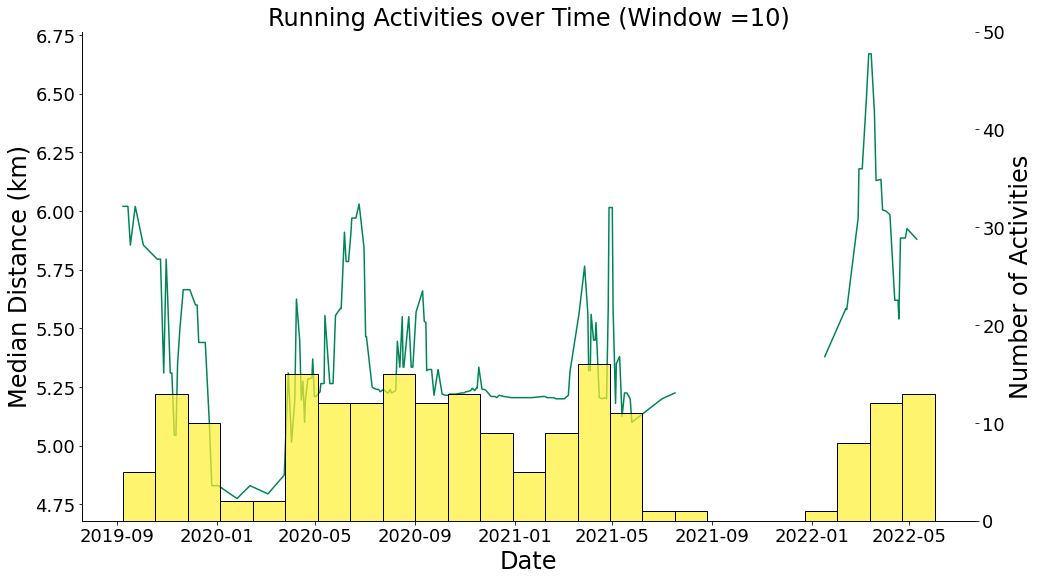

In [40]:
## Time Series Plots

features_y1 = [clean_data_y1.Rolling_Pace,clean_data_y1.Rolling_Dist,clean_data_y1.Rolling_Duration]
features_y2 = [clean_data_y2.Rolling_Pace,clean_data_y2.Rolling_Dist,clean_data_y2.Rolling_Duration]
description = ["Median Pace (min/km)","Median Distance (km)","Median Duration (mins)"]

for i in range(2):

    fig, ax1 = plt.subplots(1,1,figsize=(16,9))
    ax2 = ax1.twinx()
    sns.lineplot(clean_data_y1.Date,features_y1[i],ax=ax1,color='#018558')
    sns.lineplot(clean_data_y2.Date,features_y2[i],ax=ax1,color='#018558')
    sns.histplot(master_data.Date,ax=ax2,color='#fef031',alpha=0.7,bins=25)
    ax2.set_ylim(0,50)
    sns.despine()


    ax1.set_title("Running Activities over Time (Window =10)")
    ax1.set_ylabel(description[i])
    ax2.set_ylabel("Number of Activities")
    feature = np.where(i==1,"Distance","Pace")
    plt.savefig(f"Graphs/Date_{feature}.jpg")


In [ ]:
## Distance vs Pace
fig, ax1 = plt.subplots(1,1,figsize=(16,9))
ax2 = ax1.twinx()
sns.lineplot(clean_data_y1.Date,clean_data_y1.Rolling_Speed,ax=ax1,color='green',label='Speed')
# sns.lineplot(clean_data_y2.Date,clean_data_y2.Rolling_Speed,ax=ax1,color='green')

sns.lineplot(clean_data_y1.Date,clean_data_y1.Rolling_Dist,ax=ax2,color='red',label="Distance")
# sns.lineplot(clean_data_y2.Date,clean_data_y2.Rolling_Dist,ax=ax2,color='red')


ax1.legend(loc=3)
sns.despine()
ax1.set_title("Distance vs Pace")
ax1.set_ylabel("Speed (km/h)")
ax2.set_ylabel("Distance (km)")
plt.savefig("Graphs/Distance_Pace.jpg")

In [ ]:
## Correlations
fig, ax = plt.subplots(1,1,figsize=(16,9))
corr_df = master_data[["Rolling_Dist",'Rolling_Speed','Rolling_Duration',"Rolling_Calories",'Rolling_Climb']].corr()

mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

plt.title("Feature Correlation")
sns.heatmap(corr_df,annot=True,cbar=False)
plt.savefig("Graphs/Feature_Correlation.jpg")